In [2]:
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
taxiZoneDf = pd.read_csv('taxi_zone_lookup.csv', usecols=['LocationID', 'Borough', 'Zone'])
finalDf = pd.DataFrame([])
usecols = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
           'PULocationID', 'DOLocationID', 'total_amount']
chunksize = 1000000

In [4]:
for chunk in pd.read_csv("yellow_tripdata_2018-01.csv", chunksize=chunksize, iterator=True, usecols=usecols):
    joinDf = chunk.dropna().drop(chunk[
                                     (chunk.trip_distance <= 0)
                                     | (chunk.tpep_dropoff_datetime == chunk.tpep_pickup_datetime)
                                     | (chunk.total_amount < 0)
                                     ].index
                                 ).merge(taxiZoneDf, how='inner', left_on=['PULocationID'], right_on=['LocationID'])

    joinDf['tpep_pickup_datetime'] = pd.to_datetime(joinDf['tpep_pickup_datetime'])
    joinDf['year'] = joinDf.tpep_pickup_datetime.dt.year
    joinDf['month'] = joinDf.tpep_pickup_datetime.dt.month
    #joinDf['day'] = joinDf.tpep_pickup_datetime.dt.day
    joinDf['hour'] = joinDf.tpep_pickup_datetime.dt.hour
    #joinDf['minute'] = joinDf.tpep_pickup_datetime.dt.minute
    joinDf = joinDf.drop(joinDf[(joinDf.year != 2018) | (joinDf.month != 1)].index)
    joinDf = joinDf.groupby(['hour','Borough']).size().reset_index(name='counts')

    finalDf = pd.concat([finalDf, joinDf])

In [6]:
finalDf = pd.DataFrame(finalDf.groupby(['hour','Borough']).sum().reset_index())
finalDf.to_csv('finalDf.csv')
print(finalDf.head())

   hour    Borough  counts
0     0      Bronx     283
1     0   Brooklyn    6324
2     0        EWR       1
3     0  Manhattan  228059
4     0     Queens   17885


    hour  counts
0      0  257029
1      1  186682
2      2  140450
3      3  101229
4      4   78028
5      5   84944
6      6  195272
7      7  333689
8      8  415975
9      9  417648
10    10  403224
11    11  415899
12    12  444264
13    13  446394
14    14  475787
15    15  487361
16    16  460410
17    17  514562
18    18  572413
19    19  540393
20    20  479133
21    21  472441
22    22  436876
23    23  340402


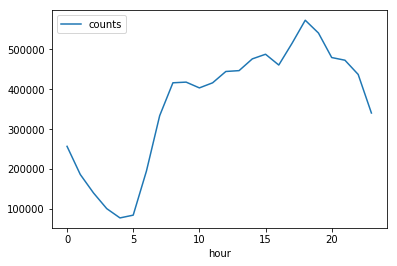

In [9]:
groupByHourDf = finalDf.groupby(['hour']).sum().reset_index()
print(groupByHourDf)
groupByHourDf.set_index('hour').plot()

                      partOfDay  hour   counts
0  1-Mid Night to Early Morning   103   848362
1                     2-Morning   274  1765808
2                        3-Noon   455  2269705
3                   4-Afternoon   630  2566911
4                       5-Night   439  1249719


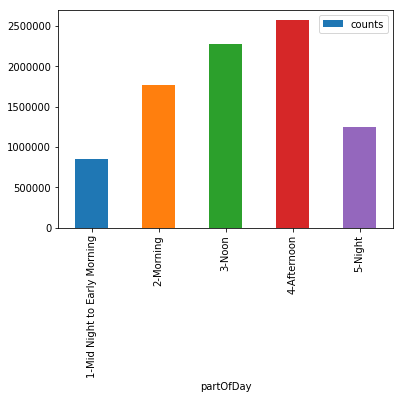

In [14]:
def partOfDay(hour):
    if hour <= 5: return "1-Mid Night to Early Morning"
    if hour <= 10 and hour > 5: return "2-Morning"
    if hour <= 15 and hour > 10: return "3-Noon"
    if hour <= 20 and hour > 15: return "4-Afternoon"
    if hour <= 24 and hour > 20: return "5-Night"
    
finalDf['partOfDay'] = finalDf['hour'].apply(partOfDay)
groupByPartOfDayDf = finalDf.groupby(['partOfDay']).sum().reset_index()
print(groupByPartOfDayDf)
groupByPartOfDayDf.set_index('partOfDay').plot.bar(y='counts')

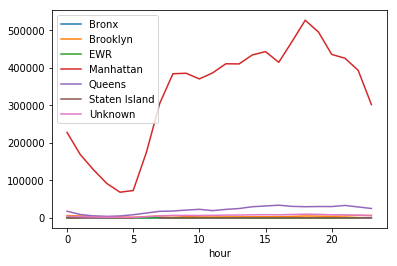

In [17]:
broughDf = pd.DataFrame(finalDf.pivot_table(values='counts', index=['hour','partOfDay'], columns='Borough').to_records())
broughDf.set_index('hour').plot()

In [21]:
#broughDf.drop(['hour'], axis=1, inplace=True)
partOfDayDf = broughDf.groupby(['partOfDay']).sum().reset_index()
print(partOfDayDf)

                      partOfDay   Bronx  Brooklyn   EWR  Manhattan    Queens  \
0  1-Mid Night to Early Morning  1464.0   23076.0  13.0   758904.0   50155.0   
1                     2-Morning  1867.0   21569.0  42.0  1621132.0   92759.0   
2                        3-Noon  1435.0   14074.0  46.0  2086437.0  128854.0   
3                   4-Afternoon  1261.0   21220.0  73.0  2343753.0  155230.0   
4                       5-Night   631.0   18443.0   6.0  1121540.0   87684.0   

   Staten Island  Unknown  
0           31.0  14719.0  
1           15.0  28424.0  
2           16.0  38843.0  
3           37.0  45337.0  
4           12.0  21403.0  


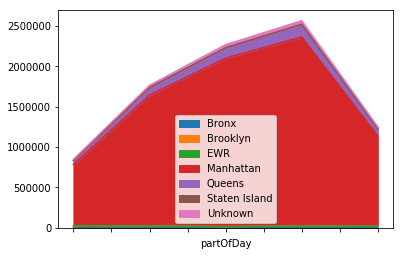

In [23]:
partOfDayDf.set_index('partOfDay').plot.area(stacked=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021602F96D30>,
      dtype=object)

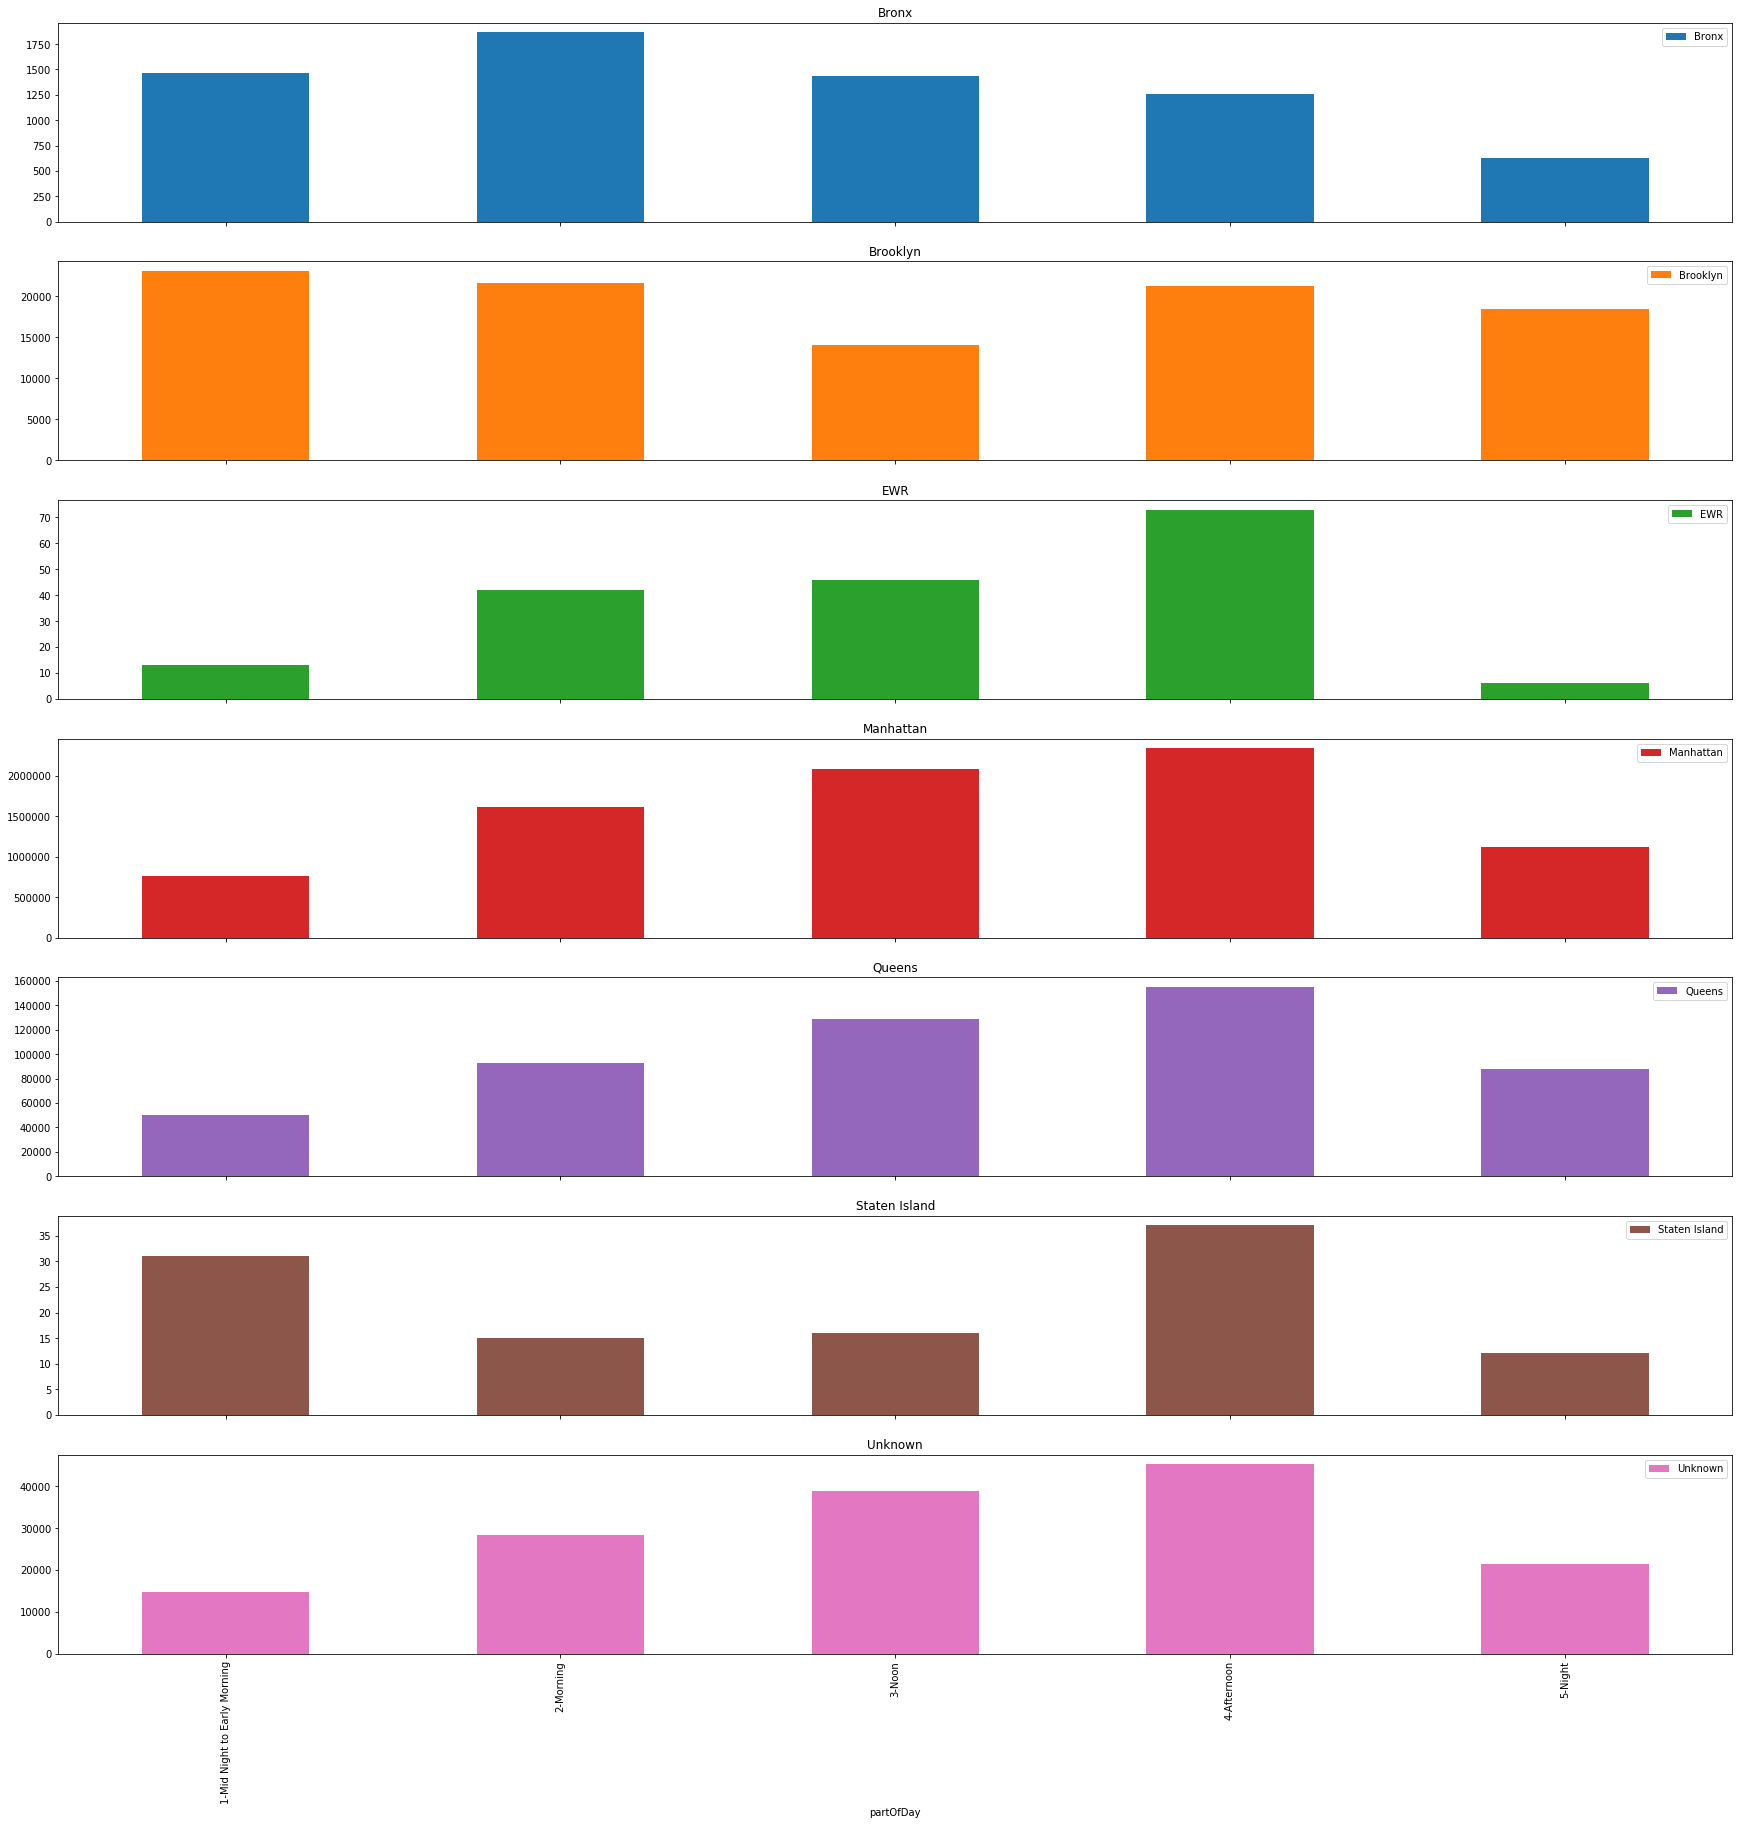

In [29]:
partOfDayDf.set_index('partOfDay').plot.bar(subplots=True,figsize =(30,30))